In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
from collections import OrderedDict

from torch.utils.data import Dataset

In [3]:
cyl_data = np.load('data_numpy.npy')

xy_coords = np.load('xy_coords.npy').T

In [4]:
''' 
Note the shape of our cylinder data:
2000 timesteps, 
3 flow descriptors (x-velocity, y-velocity, vorticity), 
8744 grid points (interpolated elements onto FEM triangle centers)

xy_coords gives array where row 1 is x-coords & row 2 is y-coords
'''
print(cyl_data.shape)
print(xy_coords.shape)

(2000, 3, 8744)
(2, 8744)


# Little Visualization Code

In [5]:
def plot_cyl(coords, field, ax, levels=18):
    numOfLevels=levels
    vort_levels = np.append(np.append(np.array([-40]),np.linspace(-2,2,numOfLevels)),40)

    ax.tricontourf(coords[0],coords[1], field, levels=vort_levels, vmin = -2,vmax=2, cmap='RdBu')
    circle = plt.Circle((0, 0), 0.5, color='grey', clip_on=False)
    ax.add_patch(circle)
    ax.set_xlim(-1.5,12)
    return ax

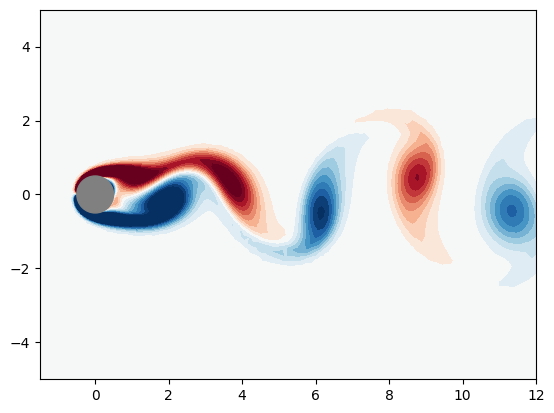

In [6]:
fig, ax = plt.subplots()
plot_cyl(xy_coords,cyl_data[-1,2,:],ax)

plt.show()

Alternatively you can use scatter plots but these kinda suck

(-2.5, 10.0)

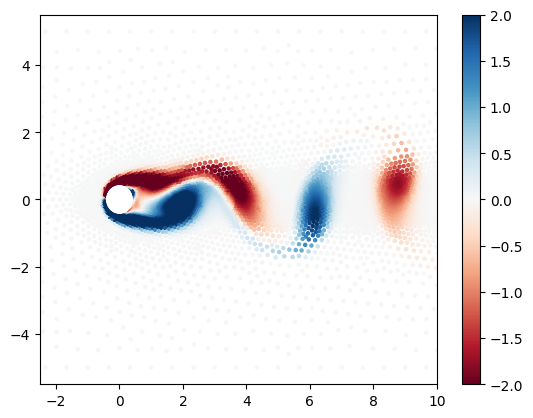

In [7]:
plt.scatter(xy_coords[0],xy_coords[1], s = 5, c = cyl_data[-1,2,:], vmin = -2,vmax=2, cmap='RdBu')
plt.colorbar()

plt.xlim(-2.5,10)

# Make a custom Torch Dataset

In [8]:
# Convert data shape and storage (list) to make torch happy
U_list = []
V_list = []
vort_list = []

for i in range(0,cyl_data.shape[0]):
    U_list.append(np.reshape(cyl_data[i,0,:], (1,8744)))
    V_list.append(np.reshape(cyl_data[i,1,:], (1,8744)))
    vort_list.append(np.reshape(cyl_data[i,2,:], (1,8744)))

In [9]:
# Data dimension must be compatible with input layer (8744,128)
print((U_list[2]).shape)

(1, 8744)


In [10]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):

        item_as_np = self.data[index]
        item_as_ten = torch.from_numpy(item_as_np).float()

        return item_as_ten

In [11]:
# Split 2000 total steps into test & train
train_cylData = CustomDataset(vort_list[:1500])
test_cylData = CustomDataset(vort_list[1500:])

# Start implementing Dima's stuff

In [12]:
# Can prob tune the batch_size
batch_size = 128
cyl_DL_train = torch.utils.data.DataLoader(train_cylData, shuffle=True, batch_size=batch_size)
cyl_DL_test = torch.utils.data.DataLoader(test_cylData, shuffle=True, batch_size=batch_size)

im_size = vort_list[0].size

In [13]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Reproducibility  
torch.manual_seed(0);

# Cylinder Data
batch_size = 32
cyl_DL_train = torch.utils.data.DataLoader(train_cylData, shuffle=True, batch_size=batch_size)
cyl_DL_test = torch.utils.data.DataLoader(test_cylData, shuffle=True, batch_size=batch_size)
im_size = vort_list[0].size

sample = next(iter(cyl_DL_train))  #grab the next batch from the dataloader

In [14]:
### Create Networks ###

#Autoencoder params
NN_width = 128 #size of hidden layers
n_hidden = 5  #number of hidden layers on either size of latent space
n_latent = 8 #size of latent space 

# Encoder as a fully connected network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        #create input layer
        Taper1 =  4096
        Taper2 = 1024
        self.l1 = nn.Linear(im_size, Taper1)
        self.a1 = nn.LeakyReLU(0.2, inplace=True)

        #create hidden layers
        layers = []
        # Implement a Taper Down
        # Taper
        layers.append(('hidden{}'.format(1),nn.Linear(Taper1, Taper2)))
        layers.append(('ReLU{}'.format(1), nn.LeakyReLU(0.2, inplace=True)))

        # Taper into NN_width
        layers.append(('hidden{}'.format(2),nn.Linear(Taper2, NN_width)))
        layers.append(('ReLU{}'.format(2), nn.LeakyReLU(0.2, inplace=True)))

        for i in range(2,n_hidden):
            layers.append(('hidden{}'.format(i+1),nn.Linear(NN_width, NN_width)))
            #layers.append(('batch norm{}'.format(i+1),nn.BatchNorm1d(NN_width)))
            layers.append(('ReLU{}'.format(i+1), nn.LeakyReLU(0.2, inplace=True)))
        self.hidden = nn.Sequential(OrderedDict(layers))

        #output layer
        self.out = nn.Linear(NN_width,n_latent)

    #forward pass
    def forward(self, x):
        x = x.view(x.size()[0],-1) #flatten the images into a vector
        x = self.l1(x)
        x = self.a1(x)
        x = self.hidden(x)
        return self.out(x)

# Decoder as a fully connected network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        #create input layer
        self.l1 = nn.Linear(n_latent, NN_width)
        self.a1 = nn.LeakyReLU(0.2, inplace=True)

        #create hidden layers
        layers = []
        for i in range(n_hidden - 2):
            layers.append(('hidden{}'.format(i+1),nn.Linear(NN_width, NN_width)))
            #layers.append(('batch norm{}'.format(i+1),nn.BatchNorm1d(NN_width)))
            layers.append(('ReLU{}'.format(i+1), nn.LeakyReLU(0.2, inplace=True)))

        # Taper out too
        Taper1 =  4096
        Taper2 = 1024

        layers.append(('hidden{}'.format(4),nn.Linear(NN_width, Taper2)))
        #layers.append(('batch norm{}'.format(i+1),nn.BatchNorm1d(NN_width)))
        layers.append(('ReLU{}'.format(4), nn.LeakyReLU(0.2, inplace=True)))

        layers.append(('hidden{}'.format(5),nn.Linear(Taper2, Taper1)))
        #layers.append(('batch norm{}'.format(i+1),nn.BatchNorm1d(NN_width)))
        layers.append(('ReLU{}'.format(5), nn.LeakyReLU(0.2, inplace=True)))

        self.hidden = nn.Sequential(OrderedDict(layers))

        #output layer
        self.out = nn.Linear(Taper1,im_size)

    #forward pass
    def forward(self, x):
        x = self.l1(x)
        x = self.a1(x)
        x = self.hidden(x)
        x = self.out(x)
        return x.view(x.size()[0],im_size) #reshape to image

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x, latent

In [16]:
net = AutoEncoder().to(device)
reconst, latent = net(sample[0].to(device))
print('Reconstructed shape:', reconst.shape)
print('Latent shape:', latent.shape)

Reconstructed shape: torch.Size([1, 8744])
Latent shape: torch.Size([1, 8])


In [17]:
#training parameters
epochs = 5          #one epoch is one iteration through the entire training cylce
iters_cycle = 200    #frequency of which to log results
error = torch.nn.L1Loss() 

In [18]:
### Train Autoencoder ###
LR = 0.001

#initialize error function and optimizer
opt = torch.optim.Adam(net.parameters(), betas=(0.5, 0.999), lr = LR)

#save losses
losses = []

#train
iters = 0

for epoch in range(epochs):
    #iterate through dataloader
    for batch in cyl_DL_train:
        #separate batch into labels and images
        images = batch[0].to(device)
        
        #make predictions
        reconst, latent = net(images)
        
        #calculate loss
        loss = error(reconst, images)
        
        #backpropagate gradients with Adam algorithm, this is the magic of pytorch and autograd
        loss.backward()
        opt.step()
        
        #reset gradients
        net.zero_grad()
        
        #save losses
        losses.append(loss.item())
        
        #log progress
        if iters%iters_cycle==0:    
            print('Epoch: {}/{}     Iter: {}     Loss: {}'.format(epoch, epochs, iters, loss.item()))
        iters +=1

Epoch: 0/5     Iter: 0     Loss: 0.9397847056388855
Epoch: 4/5     Iter: 200     Loss: 0.4901043772697449


In [19]:
#Create test dataset and load into dataloader

#display sample with label and prediction
sample_test = next(iter(cyl_DL_test))
reconst, latent = net(sample[0].to(device))

In [20]:
print(sample_test.shape)
print(reconst.shape)

torch.Size([32, 1, 8744])
torch.Size([1, 8744])


In [21]:
singleTestSnapshot = np.reshape((sample_test[0].numpy()),(im_size,))
singelTestReconstructed = np.reshape((reconst.detach().numpy()),(im_size,))

# I guess I don't need to do this??

In [22]:
print(sample_test[0].shape)
print(reconst.detach().shape)

torch.Size([1, 8744])
torch.Size([1, 8744])


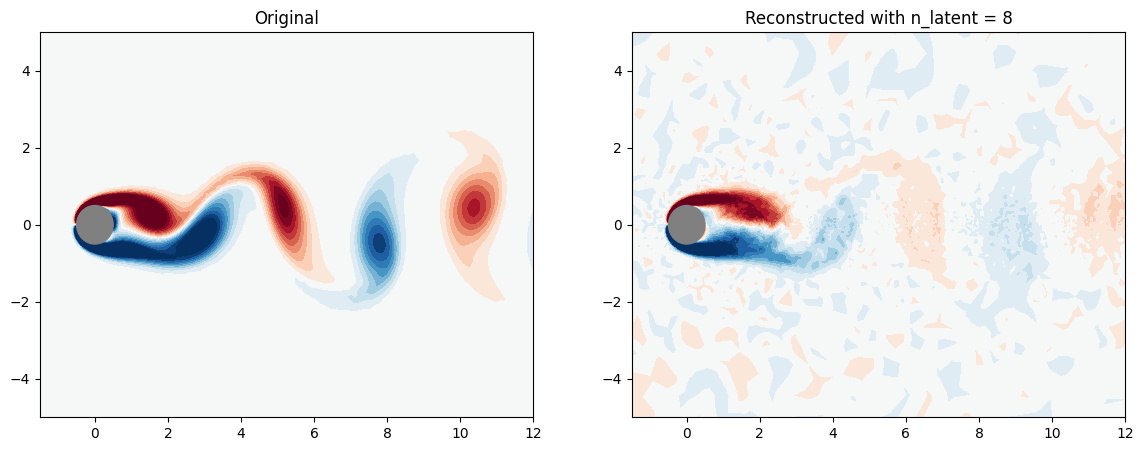

Reconstruction Error:  0.6160295605659485


In [23]:
# show image and reconstruction side by side 
# fig, ax = plt.subplots(2,1, figsize = (6,10))
# ax[0].scatter(xy_coords[0],xy_coords[1], s=5, c = sample_test[0], vmin = -2, vmax = 2, cmap='RdBu')
# ax[0].set_xlim(-2.5,10)

# ax[1].scatter(xy_coords[0],xy_coords[1], s=5, c = reconst.detach(), vmin = -2, vmax = 2, cmap='RdBu')
# ax[1].set_xlim(-2.5,10)

fig, ax = plt.subplots(1,2, figsize = (14,5))
ax[0] = plot_cyl(xy_coords, singleTestSnapshot, ax[0])
ax[1] = plot_cyl(xy_coords, singelTestReconstructed, ax[1])
ax[0].set_title('Original')
ax[1].set_title('Reconstructed with n_latent = ' + str(n_latent))
plt.show()

print("Reconstruction Error: ", error(reconst, sample[0].to(device)).item())

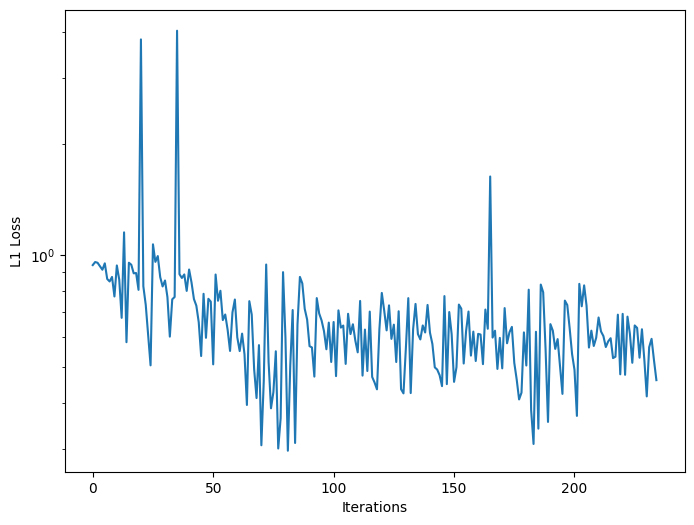

In [24]:
#plot loss curve 
plt.figure(figsize = (8,6))
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('L1 Loss')
plt.yscale('log')
plt.show()

Needs Improvement:
- More Data
- Custom Loss